## Theory

#### Sequences

- 1 feature dimension: Time
- Data nearby in time are also similar in value

#### 1D Convolution

- slide filter along every position in time (i.e the sequence)

#### Filter Shape:

- For images: Input Feature Dimension + 2 spatial Dimensions H x W + Output Feature Dimension = C1 x H x W x C2
- For Sequences: Input Feature Dimension + 1 time dimension + output feature dimension = C1 x T x C2

#### How to view CNN relative to sequences

- like a sliding dot product searching for correlation within sequences
- Checking how similar that given portion of the sequence is similar to the filter

#### Input data

- need T x D input
- ["I", "Like", "Cats"] -> [30, 251, 6] -> [vec1, vec2, vec3] (vec is of size D)
- T sequence of words, of vector size D = T x D


In [8]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("spam_or_not_spam.csv")
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [5]:
df.isna().sum()

email    1
label    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [9]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['email'], df['label'].values, test_size=0.33)

In [10]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train) # converts sentences into tokens
sequences_train = tokenizer.texts_to_sequences(df_train) # convert tokens to indices
sequences_test = tokenizer.texts_to_sequences(df_test) 

In [11]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens")

Found 28720 unique tokens


In [ ]:
# pad sequences to get N x T matrix
data_train = pad_sequences(sequences_train) # make all sentences have equal length

T = data_train.shape[1]
print(f"Shape of data train tensor: {data_train.shape}")
# 7417 is length of longest sentence

Shape of data train tensor: (2009, 7417)


In [13]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f"Shape of data test tensor: {data_test.shape}")

Shape of data test tensor: (990, 7417)


### Build Model


In [16]:
D = 20 # Embedding dimensions
kernel_size = 3

# size of embedding is V + 1 because not 0-indexing
# so if final index is V, then size is V + 1

i = Input(shape=(T, )) # T is the sentence length (sequence length)
x = Embedding(V + 1, D)(i) # Converts the sequence of index into embedding vector (T x D)

x = Conv1D(32, kernel_size, activation='relu')(x)
x = MaxPooling1D(kernel_size)(x)

x = Conv1D(64, kernel_size, activation='relu')(x)
x = MaxPooling1D(kernel_size)(x)

x = Conv1D(128, kernel_size, activation='relu')(x)
x  = GlobalMaxPooling1D()(x) # select only max value from 128 feature maps, thus output will be 1 x D

x = Dense(1, activation='sigmoid')(x) # single output predicting spam or not 

model = Model(i, x)





## Compile & Fit


In [17]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    data_train, Ytrain,
    epochs=5,
    validation_data=(data_test, Ytest)
)

Epoch 1/5
63/63 [==============================] - 2s 32ms/step - loss: 0.4451 - accuracy: 0.8382 - val_loss: 0.3945 - val_accuracy: 0.8242
Epoch 2/5
63/63 [==============================] - 2s 31ms/step - loss: 0.2442 - accuracy: 0.8746 - val_loss: 0.1627 - val_accuracy: 0.9545
Epoch 3/5
63/63 [==============================] - 2s 31ms/step - loss: 0.0424 - accuracy: 0.9920 - val_loss: 0.0493 - val_accuracy: 0.9838
Epoch 4/5
63/63 [==============================] - 2s 32ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0346 - val_accuracy: 0.9848
Epoch 5/5
63/63 [==============================] - 2s 32ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0277 - val_accuracy: 0.9889


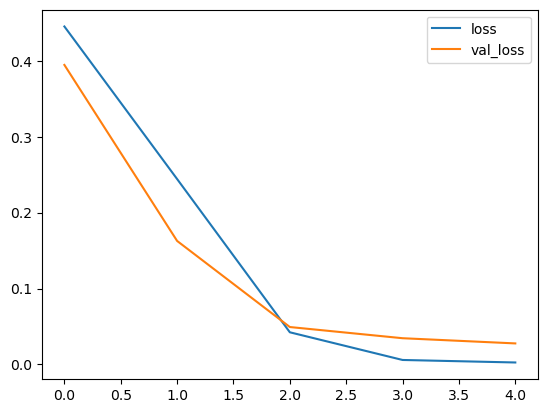

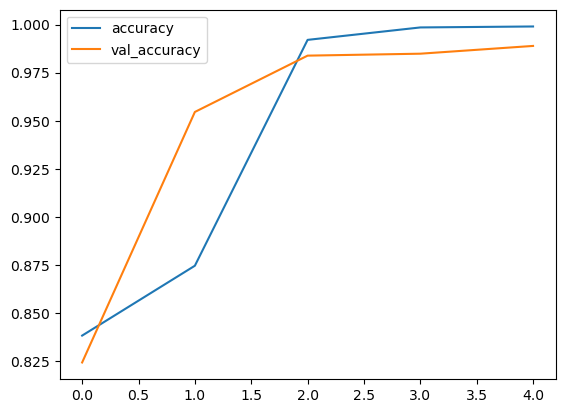

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()